В проектируемой локальной сети есть заданное количество компьютеров.
Есть расстояния от каждого компьютера до сервера и до остальных компьютеров. Маршрутизаторы соединяются с сервером через оптоволокно стоимостью 12 р/м, а компьютеры - с маршрутизаторами соединяются через витую пару стоимостью 30 р/м.
Каждый маршрутизатор имеет 8 портов для витой пары и один оптический порт.
Сервер имеет неограниченное число оптических портов и портов для витой пары. Компьютер может соединяться с сервером напрямую или через маршрутизатор.
1. Построить ЦФ для расчёта стоимости оборудования ЛВС в общем виде. Учесть стоимость маршрутизатора, обоснованность его установки.

In [194]:
import numpy as np
from matplotlib import pyplot as plt
from collections import OrderedDict
from collections import ChainMap

In [204]:
num_computers = 10 #число компьютеров в ЛВС
metr_optovol = 12 #стоимость одного метра оптоволокна
metr_para = 30 #стоимость одного метра витой пары
router_cost = 300 #стоимость маршрутизатора
max_ports = 8 #максимальное число портов у маршрутизатора

In [196]:
np.random.seed(0)
x = np.random.randint(0, 100, num_computers)
y = np.random.randint(0, 100, num_computers)
server = np.random.randint(0, 100, 2)
print(x,y,server)

[44 47 64 67 67  9 83 21 36 87] [70 88 88 12 58 65 39 87 46 88] [81 37]


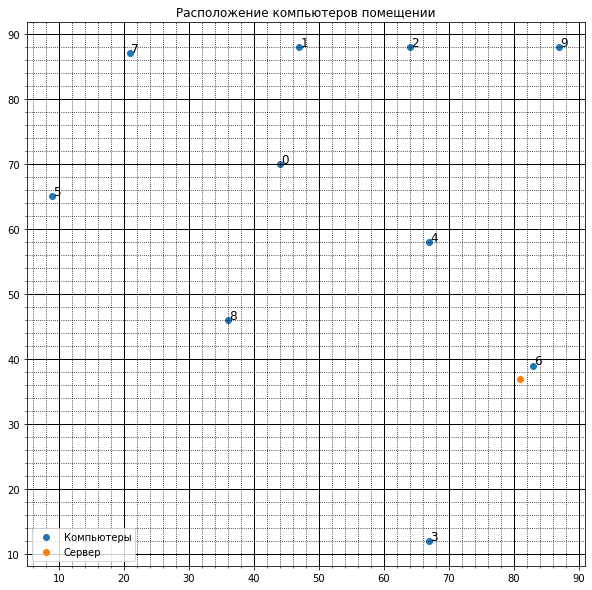

In [197]:
fig, ax = plt.subplots()

ax.scatter(x, y, label="Компьютеры")
ax.scatter(server[0], server[1], label="Сервер")
plt.legend()

ax.minorticks_on()
ax.grid(which='major',
        color = 'k', 
        linewidth = 1)
ax.grid(which='minor', 
        color = 'k', 
        linestyle = ':')
fig.set_figwidth(10)
fig.set_figheight(10)
plt.title('Расположение компьютеров помещении')
for i in range(num_computers):
    ax.annotate(i, (x[i]+.15, y[i]+.2), size=12)
plt.show()

In [198]:
def get_distance(x1, x2, y1, y2):
    return np.sqrt((x2-x1)**2+(y2-y1)**2)

In [199]:
#возвращает стоимость ЛВС в зависимости от координат роутера и числа используемых портов
def get_price_network(r_x, r_y, num_ports, set_comps, routers_list):
    
    price = 0
    d = {}
    
    for i in set_comps:
        distance = get_distance(x[i], r_x, y[i], r_y)
        d[i] = round(distance, 2)
    new_d = OrderedDict(sorted(d.items(), key=lambda t: t[1]))
    
    while len(new_d) > num_ports:
        comp_del = new_d.popitem(last=True)[0]
        #узнаем какое расстояние от компьютера до сервера
        distance = get_distance(x[comp_del], server[0], y[comp_del], server[1])
        price = price + metr_para * distance
    
    #прибавляем стоимость роутера
    price = price + router_cost 
    for key in new_d:
        distance = get_distance(x[key], r_x, y[key], r_y)
        price = price + metr_para * distance
    
    #прибавим стоимость оптоволокна от роутера до сервера
    distance = get_distance(server[0], r_x, server[1], r_y)
    price = price + metr_optovol * distance
    
    #прибавим стоимость роутеров, полученных на предыдущих итерациях
    price = price + len(routers_list*router_cost)
    
    #прибавим стоимость витой пары с каждого роутера, полученных на предыдущих итерациях, а также расстояния от роутера до сервера
    for i in routers_list:
        price += i['meters_para'] * metr_para
        distance = get_distance(i['x'], server[0], i['y'], server[1])
        price += distance * metr_optovol
    
    price = round(price, 2)
    return new_d, price

In [205]:
price = 0
d = 0
for i in range(num_computers):
    d += get_distance(x[i], server[0], y[i], server[1])
price = d * metr_para
price = round(price, 2)

print(f'Стоимость подключения каждого компьютера к серверу напрямую: {price}, руб.')

routers_list = []
comps = set(range(num_computers))

while len(comps) > 0:
    
    if len(comps) < max_ports:
        max_ports = len(comps)
    
    flag = False 
    r = {}
    final_d = {}
    
    for i in range(100):
        for j in range(100):
            for num in range(max_ports):
                new_d, price_ = get_price_network(i, j, num, comps, routers_list)
                if price_ < price:
                    flag = True
                    price = price_
                    r['x'] = i
                    r['y']= j
                    final_d = new_d
    r['num_comps'] = len(final_d)
    r['meters_para'] = round(sum(final_d.values()),2)
    r['comps'] = set(final_d)
 
    router = ChainMap(r, final_d)
    #print(router)
    routers_list.append(router)
    if flag == False:
        print('break')
        break; #остались компьютеры, подключенные к серверу напрямую, но цена в меньшую сторону уже не меняется
    
    comps = comps - r['comps']
    print(comps)
    
print(f"Стоимость ЛВС с маршрутизаторами {price}")
print(routers_list)


Стоимость подключения каждого компьютера к серверу напрямую: 14218.5, руб.
{9, 3, 6}
{3, 6}
{6}
break
Стоимость ЛВС с маршрутизаторами 7350.65
[ChainMap({'x': 44, 'y': 70, 'num_comps': 7, 'meters_para': 160.36, 'comps': {0, 1, 2, 4, 5, 7, 8}}, OrderedDict([(0, 0.0), (1, 18.25), (8, 25.3), (4, 25.94), (2, 26.91), (7, 28.6), (5, 35.36)])), ChainMap({'x': 87, 'y': 88, 'num_comps': 1, 'meters_para': 0.0, 'comps': {9}}, OrderedDict([(9, 0.0)])), ChainMap({'x': 67, 'y': 12, 'num_comps': 1, 'meters_para': 0.0, 'comps': {3}}, OrderedDict([(3, 0.0)])), ChainMap({'num_comps': 0, 'meters_para': 0, 'comps': set()}, {})]


В итоге для моего примера получилось три маршрутизатора:
* 1 - связал собой 7 компьютеров (0, 1, 2, 4, 5, 7, 8) координаты 'x': 44, 'y': 70
* 2 - подключен к компьютеру 9 координаты 'x': 87, 'y': 88
* 3 - подключен к компьютеру 3 координаты 'x': 67, 'y': 12

* компьютер номер 6 подключен к серверу напрямую.